In [6]:
import numpy as np
import torchvision
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from skimage import io
import torch
import torch.nn as nn
from einops import rearrange, repeat
import pandas as pd
import sys
sys.path.insert(0, '../utils/')
from dataset import ChestImage64
import os
import time
import datetime

import matplotlib.pyplot as plt

from torchvision.models import vit_l_16, ViT_L_16_Weights,vit_b_16, ViT_B_16_Weights
from torch.utils.data import random_split, DataLoader, Dataset


In [7]:
# csv_path = "../64pxImages/train_labels_64p.csv"
# root_path = '../64pxImages'

csv_path = "../256pxImages/train_labels_256p.csv"
root_path = '../256pxImages'


default_transform = ViT_L_16_Weights.IMAGENET1K_SWAG_LINEAR_V1.transforms


data_transform = Compose([
    Resize((64, 64)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])



In [8]:
myCSV = pd.read_csv(csv_path)
myCSV['EncodedLabels'] = ''
print(myCSV.shape)


# for i in range(4, myCSV.shape[1]-1):
#     myCSV['EncodedLabels'] = myCSV['EncodedLabels'].astype(str) + myCSV.iloc[:, i].astype(str) 
#     if i < myCSV.shape[1]-2:
#         myCSV['EncodedLabels'] = myCSV['EncodedLabels'].astype(str) + "," 

for i in range(4, myCSV.shape[1]-1):
    myCSV['EncodedLabels'] = myCSV['EncodedLabels'].astype(str) + myCSV.iloc[:, i].astype(str) 
    if i < myCSV.shape[1]-2:
        myCSV['EncodedLabels'] = myCSV['EncodedLabels'].astype(str) + "," 



# myCSV['EncodedLabels'] = myCSV['EncodedLabels'].astype(str) + "]"


# We can use the encodedlabels column as our labels for our data

# since we are not useing cross attention, pull out only the frontal images. 
frontalCSV = myCSV[myCSV['Frontal/Lateral'].str.contains("Frontal")]
frontalCSV.head()

filename = frontalCSV.iloc[1, 0]
label_test = frontalCSV['EncodedLabels'].iloc[0]

test_path = os.path.join(root_path, filename)


label_test = [int(x) for x in label_test.split(",")]

print("label_test: ", label_test)

image = io.imread(test_path)
print(type(image))
image = torch.tensor(image)
print(image.size())

(61266, 19)
label_test:  [1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0]
<class 'numpy.ndarray'>
torch.Size([256, 256])


In [9]:
myCSV.head()

,256path,Patient,Study,Frontal/Lateral,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,No Finding,EncodedLabels
0,Frontal\patient00002_study1_Frontal.png,patient00002,study1,Frontal,1,1,1,1,0,1,1,1,0,0,1,1,0,0,"1,1,1,1,0,1,1,1,0,0,1,1,0,0"
1,Lateral\patient00002_study1_Lateral.png,patient00002,study1,Lateral,1,1,1,1,0,1,1,1,0,0,1,1,0,0,"1,1,1,1,0,1,1,1,0,0,1,1,0,0"
2,Frontal\patient00004_study1_Frontal.png,patient00004,study1,Frontal,0,0,0,0,0,0,0,0,0,0,0,0,0,1,"0,0,0,0,0,0,0,0,0,0,0,0,0,1"
3,Lateral\patient00004_study1_Lateral.png,patient00004,study1,Lateral,0,0,0,0,0,0,0,0,0,0,0,0,0,1,"0,0,0,0,0,0,0,0,0,0,0,0,0,1"
4,Frontal\patient00005_study1_Frontal.png,patient00005,study1,Frontal,0,0,0,0,0,0,0,0,0,0,0,0,1,0,"0,0,0,0,0,0,0,0,0,0,0,0,1,0"


In [26]:
# load up the dataset
class CustomDataset(Dataset):
    def __init__(self, df, root_dir, label_col, transform = None):
        self.df = df
        self.root_dir = root_dir
        self.label_col = label_col
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):

        if torch.is_tensor(index):
            index = index.tolist()

        # get the filename of the image
        filename = self.df.iloc[index, 0]
        label = self.df[self.label_col].iloc[index]

        if type(label) == str:
            label = [int(x) for x in label.split(",")]

        # load the image from disk
        path = os.path.join(self.root_dir, filename)
        img = io.imread(path)



        label = torch.tensor(label)
        label = label.float()
        img = torch.tensor(img)
        img = img.resize_((224, 224))
        img = repeat(img, "h w -> (repeat h) w", repeat = 3)
        img = rearrange(img, "(c h) w -> c h w", c = 3)
        img = img.float()


        # if self.transform:
            # label = self.transform(label)
            # img = self.transform(img)

        # return the image and its filename
        return img, label
    

dataset = CustomDataset(frontalCSV, root_dir=root_path, label_col="EncodedLabels", transform=default_transform)

print(type(dataset))

# split into test train validate
train_size = int(0.7 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = int(0.2 * len(dataset))


train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print("Train Length: ", len(train_dataset))
print("Validation Length: ", len(val_dataset))
print("Test Length: ", len(test_dataset))

batchsize = 16

# make three different dataloaders
train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batchsize, shuffle=False)
test_loader = DataLoader(test_dataset,batch_size=batchsize, shuffle=True)


features, labels = next(iter(train_loader))
print(features.size())
print(features.dtype)

print(features[1, 1, :, :])

print(labels.size())
print(datetime.datetime.now().strftime("%H:%M:%S"))


<class '__main__.CustomDataset'>
Train Length:  21441
Validation Length:  3063
Test Length:  6126
torch.Size([16, 3, 224, 224])
torch.float32
tensor([[213., 213., 212.,  ...,  53.,  53.,  53.],
        [ 53.,  52.,  52.,  ...,  32.,  32.,  32.],
        [ 31.,  31.,  32.,  ...,  30.,  30.,  30.],
        ...,
        [217., 210., 205.,  ..., 124., 134., 158.],
        [159., 151., 160.,  ..., 180., 183., 187.],
        [194., 195., 199.,  ...,  24.,  28.,  32.]])
torch.Size([16, 14])
07:53:06


In [11]:
# information about the pretrained models is coming from this link: 
#https://pytorch.org/vision/master/models.html


# just use the default weights. These should yeild the best results
#weights = ViT_L_16_Weights.DEFAULT
weights = ViT_B_16_Weights.DEFAULT
num_classes = 14
feature_extraction = False
model = vit_b_16(weights = weights)



In [22]:
epochs = 1
learning_rate = 0.003
criterion = nn.BCEWithLogitsLoss()


if feature_extraction: 
    for param in model.parameters():
        param.requires_grad = False

    # change the last layer to have the correct number of classes
    #model.heads = nn.Sequential(nn.Linear(1024, num_classes))
    model.heads = nn.Sequential(nn.Linear(768, num_classes))
    model.heads.requires_grad_ = True
else:
        #model.heads = nn.Sequential(nn.Linear(1024, num_classes))
        model.heads = nn.Sequential(nn.Linear(768, num_classes))



In [23]:
params_to_update =model.parameters()

# print out a list of the parameters we are training
for name,param in model.named_parameters():
    if param.requires_grad == True:
        print("\t",name)


	 class_token
	 conv_proj.weight
	 conv_proj.bias
	 encoder.pos_embedding
	 encoder.layers.encoder_layer_0.ln_1.weight
	 encoder.layers.encoder_layer_0.ln_1.bias
	 encoder.layers.encoder_layer_0.self_attention.in_proj_weight
	 encoder.layers.encoder_layer_0.self_attention.in_proj_bias
	 encoder.layers.encoder_layer_0.self_attention.out_proj.weight
	 encoder.layers.encoder_layer_0.self_attention.out_proj.bias
	 encoder.layers.encoder_layer_0.ln_2.weight
	 encoder.layers.encoder_layer_0.ln_2.bias
	 encoder.layers.encoder_layer_0.mlp.0.weight
	 encoder.layers.encoder_layer_0.mlp.0.bias
	 encoder.layers.encoder_layer_0.mlp.3.weight
	 encoder.layers.encoder_layer_0.mlp.3.bias
	 encoder.layers.encoder_layer_1.ln_1.weight
	 encoder.layers.encoder_layer_1.ln_1.bias
	 encoder.layers.encoder_layer_1.self_attention.in_proj_weight
	 encoder.layers.encoder_layer_1.self_attention.in_proj_bias
	 encoder.layers.encoder_layer_1.self_attention.out_proj.weight
	 encoder.layers.encoder_layer_1.self_attent

In [24]:
model.encoder.layers.encoder_layer_0

EncoderBlock(
  (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (self_attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (mlp): MLPBlock(
    (0): Linear(in_features=768, out_features=3072, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=3072, out_features=768, bias=True)
    (4): Dropout(p=0.0, inplace=False)
  )
)

In [27]:
# batch accumulation parameter
target_accumulation=32
accum_iter = target_accumulation/batchsize  
print(accum_iter)

2.0


In [28]:
# now let's train this thing. 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



# make sure the model is running on the GPU if its available
model.to(device)


params_to_update =model.parameters()

# print out a list of the parameters we are training
for name,param in model.named_parameters():
    if param.requires_grad == True:
        print("\t",name)

# Observe that all parameters are being optimized
optimizer = torch.optim.SGD(params_to_update, lr=learning_rate, momentum=0.9)


# optimizer = optim.Adam(model500k.parameters(), lr=learning_rate)

# start a clock 
print("Training Starting.")
start_time = time.time()

# create empty arrays to hold the loss results
training_losses = []
validation_losses = []
for epoch in range(epochs):
    phase = 'train'
    # set the model to training mode
    model.train()
    running_loss = 0.0

    # zero the parameter gradients at the very beginning
    optimizer.zero_grad()

    for i, data in enumerate(train_loader):
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        # optimizer.zero_grad()

        # with torch.set_grad_enabled(phase == 'train'):
        # run the training data through the model
        outputs = model(inputs)

        #calculate the loss of the model
        loss = criterion(outputs, labels)

        #Gradient accumulation
        loss = loss / accum_iter
        loss.backward()

        running_loss += loss.item()

        # weights update
        if ((i + 1) % accum_iter == 0) or (i + 1 == len(train_loader)):
            optimizer.step()
            optimizer.zero_grad()
        
            if ((i + 1) / accum_iter) % 50 == 0:    # record loss and test validation set every 50 gradient accumulations
                model.eval()
                v_running_loss = 0.0
                for v, data in enumerate(val_loader):
                    inputs, labels = data[0].to(device), data[1].to(device)
                    v_outputs = model(inputs)
                    v_loss = criterion(v_outputs, labels)
                    v_running_loss += v_loss.item()

                print("Time: ", datetime.datetime.now().strftime("%H:%M:%S"), "\tepoch: ", epoch+1, "batch: ", i+1, "Training loss: ", running_loss, "Validation loss ", v_running_loss)
                validation_losses.append(v_running_loss)
                training_losses.append(running_loss)
                running_loss = 0.0
        

        # once the validation has been completed, update the model
       
        #optimizer.step()
        # set model back to training mode


end_time = time.time()
train_time = end_time - start_time
print("Elapsed Training Time: ", datetime.timedelta(seconds = train_time))
print('Finished Training')
    

	 class_token
	 conv_proj.weight
	 conv_proj.bias
	 encoder.pos_embedding
	 encoder.layers.encoder_layer_0.ln_1.weight
	 encoder.layers.encoder_layer_0.ln_1.bias
	 encoder.layers.encoder_layer_0.self_attention.in_proj_weight
	 encoder.layers.encoder_layer_0.self_attention.in_proj_bias
	 encoder.layers.encoder_layer_0.self_attention.out_proj.weight
	 encoder.layers.encoder_layer_0.self_attention.out_proj.bias
	 encoder.layers.encoder_layer_0.ln_2.weight
	 encoder.layers.encoder_layer_0.ln_2.bias
	 encoder.layers.encoder_layer_0.mlp.0.weight
	 encoder.layers.encoder_layer_0.mlp.0.bias
	 encoder.layers.encoder_layer_0.mlp.3.weight
	 encoder.layers.encoder_layer_0.mlp.3.bias
	 encoder.layers.encoder_layer_1.ln_1.weight
	 encoder.layers.encoder_layer_1.ln_1.bias
	 encoder.layers.encoder_layer_1.self_attention.in_proj_weight
	 encoder.layers.encoder_layer_1.self_attention.in_proj_bias
	 encoder.layers.encoder_layer_1.self_attention.out_proj.weight
	 encoder.layers.encoder_layer_1.self_attent

In [29]:
print(type(outputs))
print(outputs.size())
print(outputs[1, :])
print(labels.size())
print(labels[1, :])
print(outputs.dtype)
print(labels.dtype)
print(loss)

print(training_losses)

<class 'torch.Tensor'>
torch.Size([1, 14])


IndexError: index 1 is out of bounds for dimension 0 with size 1

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


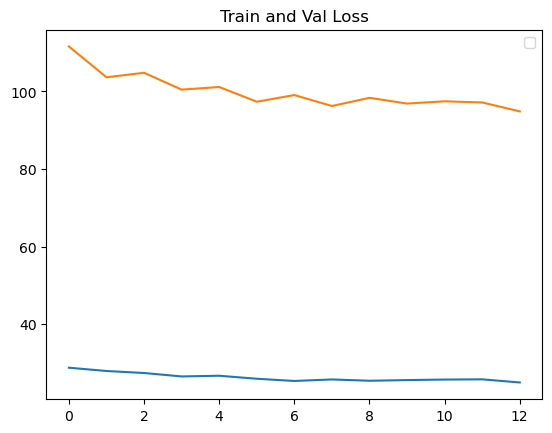

In [30]:
plt.title("Train and Val Loss")
plt.plot(training_losses)
plt.plot(validation_losses)
plt.legend()